# Table of contents
1. [Purpose](#purpose)
2. [Inputs](#inputs)
    * [2.1 GAP Species Range Maps](#subinput1)
    * [2.2 GAP Species Habitat Maps](#subinput2)
3. [Outputs](#outputs)
4. [Constraints](#constraints)
5. [Dependencies](#dependencies)
    * [5.1 Code Language](#codelanguage)
      * [5.1.1 package requirements](#packagerequirements)

6. [Code](#code)
    * [6.1 ScienceBase Connection Functions](#code61)
    * [6.2 Calculating Species Range and Habitat Areas](#code62)
7. [Tests](#tests)
8. [Provenance](#provenance)
9. [Citations](#citations)
---

# Comparing Areal Extent of GAP Species' Range and Habitat Maps
<br/>

## Purpose <a name="purpose"></a>
A number of authors have explored methods for delineating the geography of species’ distributions (e.g. Graham and Hijmans 2006, Jetz et al. 2008, Gaston and Fuller 2009, Beresford et al. 2011). Researchers commonly distinguish between extent of occurrence (EOO), and extent of suitable habitat (ESH) to describe range-based and habitat-based geographic representation respectively. Techniques for generating EOO and ESH vary widely which can have significant effects on estimations such as population size (Freckleton et al. 2006), protection status, and richness measurements (Rondinini et al. 2011, McKerrow et al. 2018). Typically, ESH is viewed as a subset of EOO, that is, species habitat is a combination of physiographic, biological, and climatological landscape attributes within a broad extent where a given species is known to occur. Comparing range and habitat extent (EOO and ESH) across numerous taxa can reveal a number of important conservation concern attributes including habitat specialization, endemism, and extinction risk (Jetz et al. 2008, Harris and Pimm 2008, Gaston and Fuller 2009).

The U.S. Geological Survey Gap Analysis Project (GAP) created range and habitat maps for 1590 terrestrial vertebrates that are known to occur within the conterminous United States (CONUS) including 219 sub-species (McKerrow et al. 2018). GAP species maps individually or in any variety of species groupings have a number of uses to aid scientists, managers and policy makers in biodiversity research and planning. Comparing the extent of occurrence and habitat for amphibians, birds, mammals, and reptiles throughout CONUS can provide quantifiable insights into attributes that may highlight conservation concerns previously overlooked in assessments of species’ geographies.

## Inputs <a name="inputs"></a>
The code in this notebook examines the relationship between species' range and habitat maps developed by the U.S. Geological Survey Gap Analysis Project (McKerrow et al. 2018). All 1719 vertebrate species taxa (species and sub-species) in four groups (amphibians, birds, mammals, and reptiles) considered present in the conterminous US at some time in their life history are included in the analyses. The input processing species list could be altered to conduct a species subset analysis.
    
It utilizes individual species range and habitat data available on the [USGS ScienceBase data catalog](https://www.sciencebase.gov/catalog/) as attached files in each species' child item. These files are available programmatically using the Python language with the USGS developed [sciencebasepy API package](https://github.com/usgs/sciencebasepy).

* ### U.S. Geological Survey Gap Analysis Project (GAP) Species Range Maps <a name="subinput1"></a>
Individual GAP species' range maps are available on ScienceBase as zip archive files containing Geographic Information System (GIS) vector data in shapefile format. The dataset is described here: https://www.sciencebase.gov/catalog/item/5951527de4b062508e3b1e79.

* ### U.S. Geological Survey Gap Analysis Project (GAP) Species Habitat Maps <a name="subinput2"></a>
Individual GAP species' habitat maps are available on ScienceBase as zip archive files containing GIS raster data in TIF format. The dataset is described here: https://www.sciencebase.gov/catalog/item/527d0a83e4b0850ea0518326.

Additionally, the code utilizes two files for processing range and habitat map data for each individual species - one available as a local text file and the other through the ScienceBase API.
* **HUC12s.txt**  
This file is a list of all 12-digit HUC codes in the conterminous US used in developing species range maps. It contains the areal extent of each HUC polygon in square meters and is used to calculate total areal extent of each species' range. Documentation and availability for the 12-digit HUC dataset is available here: https://www.sciencebase.gov/catalog/item/56d496eee4b015c306f17a42.


* **ScienceBaseHabMapCSV_20180713.csv**  
This file is a list of all GAP modeled taxa, their scientific and common names and six-letter species codes. It is used as the species list source for programmitic looping. It is available as an attached file on ScienceBase here: https://www.sciencebase.gov/catalog/item/5951527de4b062508e3b1e79.

## Outputs <a name="outputs"></a>
A chart visualizing the relationship between species' range and habitat area and OLS regression output for the same:
* [Range vs. Habitat Scatterplot with Trendline:](#scatterplot)
A scatterplot and linear model trendline comparing the area of range to the area of habitat for each species. Each taxa group is represented by a different color and marker symbol. Values on the X and Y axes are log10 transformed to condense the chart.  


* [OLS Regression Summary:](#OLSsummary)
A results summary of ordinary least squares regression using habitat area as the dependent variable and range area as the independent variable. Analyses are conducted using the Python module [StatsModels](http://www.statsmodels.org/devel/regression.html#module-statsmodels.regression.linear_model).

## Constraints <a name="constraints"></a>
Range and habitat mapping constraints. See user constraints section on the USGS ScienceBase [GAP Species Habitat Maps](https://www.sciencebase.gov/catalog/item/527d0a83e4b0850ea0518326) page

## Dependencies <a name="dependencies"></a>
Code execution and output visualization dependencies

* ### Code Language <a name="codelanguage"></a>
This code is written in Python 3.x. Earlier versions may be compatible given slight alterations in syntax and package components.
  * #### Python package requirements <a name="packagerequirements"></a>
  The required packages for proper code execution inlclude:
    - Pandas version 0.2x or above
    - glob version 0.6 or above
    - numpy version 1.14.x or above
    - matplotlib (figures library) version 2.2.x or above
    - seaborn (statistical data visualization package) version 0.8 or above
    - statsmodel (statistical modeling package) 0.9.0 or above
    - simpledbf (for converting dbf files to Pandas dataframes) version 0.2.6 or above
    - requests HTTP library version 2.18.4 or above
    - zipfile for working with zip archive documents
    - sciencebasepy - USGS written Python package for interacting with the USGS ScienceBase API


## Tests <a name="tests"></a>


## Provenance <a name="provenance"></a>

## Code <a name="code"></a>

### Define functions for accessing species' range and habitat data through USGS ScienceBase <a name="code61"></a>

In [4]:
##############################################################################
def download_GAP_range_CONUS2001v1(gap_id, toDir):
    """
    Downloads GAP Range CONUS 2001 v1 file and returns path to the unzipped
    file.  NOTE: doesn't include extension in returned path so that you can
    specify if you want csv or shp or xml when you use the path.
    """
    import sciencebasepy
    import zipfile
    import requests
    from io import BytesIO

    # Connect
    sb = sciencebasepy.SbSession()

    # Search for gap range item in ScienceBase
    gap_id = gap_id[0] + gap_id[1:5].upper() + gap_id[5]
    item_search = '{0}_CONUS_2001v1 Range Map'.format(gap_id)
    items = sb.find_items_by_any_text(item_search)

    # Get a public item.  No need to log in.
    rngID =  items['items'][0]['id']
    item_json = sb.get_item(rngID)
    rngzipURL = item_json['files'][0]['url']
    r = requests.get(rngzipURL)
    z = zipfile.ZipFile(BytesIO(r.content))

    # Get ONLY the VAT dbf file and extract it to the designated directory
    rngCSV = [y for y in sorted(z.namelist()) for end in ['csv'] if y.endswith(end)]
    csvFile = z.extract(rngCSV[0], toDir)
    z.close()
    
    # Return the extracted range CSV
    return csvFile

##############################################################################
##############################################################################
def download_GAP_habmap_CONUS2001v1(gap_id, toDir):
    """
    Downloads GAP Habitat Map CONUS 2001 v1 file and returns path to the unzipped
    file.  NOTE: doesn't include extension in returned path so that you can
    specify if you want csv or shp or xml when you use the path.
    """
    import sciencebasepy
    import zipfile
    import requests
    from io import BytesIO

    # Connect
    sb = sciencebasepy.SbSession()

    # Search for gap range item in ScienceBase
    gap_id = gap_id[0] + gap_id[1:5].upper() + gap_id[5]
    item_search = '{0}_CONUS_2001v1 Habitat Map'.format(gap_id)
    items = sb.find_items_by_any_text(item_search)

    # Get a public item.  No need to log in.
    habID =  items['items'][0]['id']
    item_json = sb.get_item(habID)
    habzipURL = item_json['files'][2]['url']
    r = requests.get(habzipURL)
    z = zipfile.ZipFile(BytesIO(r.content))
    
    # Set global Scientific and Common name variables from item JSON
    global CN 
    CN = item_json['identifiers'][1]['key']
    global SN
    SN = item_json['identifiers'][2]['key']

    # Get ONLY the VAT dbf file and extract it to the designated directory
    habDBF = [y for y in sorted(z.namelist()) for end in ['dbf'] if y.endswith(end)]
    dbfFile = z.extract(habDBF[0], toDir)
    z.close()

    # Return path to VAT dbf file
    return dbfFile

##############################################################################

### Define functions to calculate range and habitat area based on species' maps <a name="code62"></a>

In [5]:
##############################################################################
def GetHabitatArea(spcode, tDir):
    
    import glob
    from simpledbf import Dbf5

    ''' ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    Get HABITAT data based on species' model outputs from SB file downloads
    '''
    print("\n\n++++++++++++++ Running calculations based on HABITAT +++++++++++++++++\n")
    
    # Get the name of the raster VAT dbf file for data on the number
    # of habitat cells in the species habitat map
    habDBF = glob.glob(tDir + '{0}*tif.vat.dbf'.format(spcode))[0]
    # Make it a dataframe using simpledbf
    dbf = Dbf5(habDBF)
    dfDBF = dbf.to_dataframe()
    # Make sure all the column names are UPPERCASE - some vat dbf's have a mixture of cases
    # Calculations using column names that aren't exact will throw a KeyError
    dfDBF.columns = map(str.upper, dfDBF.columns)
    
    print("---> Calculating total habitat area and proportion ....")
    # Make and empty data list for the species habitat count data
    cntdata = []
    # Calculate the km2 area for the species habitat count data
    #  the proportion of CONUS and add the species code as index
    cntsum = dfDBF['COUNT'].sum()
    cntdata.append({'SpeciesCode':spcode,
                    'AreaHab_km2':cntsum * 0.0009,
                    'PropHab_CONUS':cntsum/cntLC
                   })
    # Append the data to a dataframe that will be joined with HUC 12 data
    dfHabCounts = pd.DataFrame(data=cntdata)
    dfHabCounts = dfHabCounts[['SpeciesCode','AreaHab_km2','PropHab_CONUS']]
    dfHabArea = dfHabCounts.set_index(keys=['SpeciesCode'])
   
    return dfHabArea

##############################################################################
##############################################################################
def GetRangeArea(spcode, tDir):
    
    import glob
    
    ''' ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    Get HUC range data from the Species Database from SB file downloads
    '''
    print("\n++++++++++++++ Running calculations based on RANGES +++++++++++++++++\n")
    
    # This gets the name of the extracted range CSV file
    rangeCSV = glob.glob(tDir + '{0}*.csv'.format(spcode))[0]
    # make it a dataframe
    dfRangeCSV = pd.read_csv(rangeCSV,dtype={'strHUC12RNG':object},sep=',')
    
    # Pull in data from the HUC shapefile table (currently a static
    #  text file located at D:/USGS Analyses/Richness/data/HUCs12.txt)
    dfHUCsTable = pd.read_csv(HUCfile, dtype={'HUC12RNG':object},thousands=',',decimal='.')
    # Add an area field calculated in km2
    print("---> Calculating range area in km2 ....")
    dfHUCsTable['AreaRange_km2'] = dfHUCsTable['Shape_Area']/1000000
    # Drop some unnecessary fields
    dfHUCsTable = dfHUCsTable.drop(['FID','HUC_10','HUC_12','HUC_8', 'OBJECTID',
    'STATES','Shape_Area','Shape_Leng'], axis=1)
    
    # Now merge species range HUCs dataframe with HUC shapefile dataframe
    dfSppHUCs = pd.merge(left=dfRangeCSV, right=dfHUCsTable, how='inner',
     left_on='strHUC12RNG', right_on='HUC12RNG')
    
    # Get a row and column count from the above dataframe
    # The number of rows is the total number of HUCs in the species' range
    (r,c) = dfSppHUCs.shape
    
    # Sum the total area of each HUC (this is in km2)
    sSum = dfSppHUCs.groupby(['strUC'])['AreaRange_km2'].sum()
    dfRangeArea = pd.DataFrame(data=sSum)
    dfRangeArea.index.name = 'SpeciesCode'
    
    # Add a scientific and common names   
    dfRangeArea['ScientificName'] = SN
    dfRangeArea['CommonName'] = CN
    # Add a field with the total number of HUCs in the species' range
    print("---> Calculating number of HUCs in species' range ....")
    dfRangeArea['nHUCs'] = r
    # Add a field to calculate the proportion of CONUS for the species' range
    print("---> Calculating proportion of species' range in CONUS ....")
    dfRangeArea['Prop_CONUS'] = dfRangeArea['AreaRange_km2']/CONUSArea
    # Reorder columns
    dfRangeArea = dfRangeArea[['ScientificName','CommonName',
     'AreaRange_km2','nHUCs','Prop_CONUS']]
    
    return dfRangeArea

##############################################################################

### Import required Python packages

In [6]:
import os, sys, shutil, sciencebasepy
import pandas as pd
import numpy as np
from datetime import datetime
from io import StringIO

### Set local variables

In [8]:
analysisDir = 'C:/Data/USGS Analyses/'
workDir = analysisDir + 'Range-vs-Habitat/'
tempDir = workDir + 'downloadtemp/'
# ****** Static Range HUCs Table **********
HUCfile = workDir + 'HUC12s.txt'

starttime = datetime.now()
timestamp = starttime.strftime('%Y-%m-%d')


# Make temporary directory for downloads
#  remove it if it already exists
if os.path.exists(tempDir):
    shutil.rmtree(tempDir)
    os.mkdir(tempDir)
else:
    os.mkdir(tempDir)


### Create a function to assemble a list of species that may encounter errors while accessing ScienceBase data

In [9]:
'''
    Function to write an error log if a species' occurrence records
    server connection cannot be made - i.e. a 5xx number error.
'''
log = workDir + 'Species-Data-Access-Error-Log.txt'
def Log(content):
    with open(log, 'a') as logDoc:
        logDoc.write(content + '\n')


#### Make some static variables holding CONUS wide data

In [10]:
# STATIC VARIABLES
CONUSArea = 8103534.7   # 12-Digit HUC CONUS total area in km2
nHUCs = 82717.0         # Number of 12-digit HUCS in CONUS
cntLC = 9000763993.0    # Cell count of CONUS landcover excluding 0s
cntLCnoW = 8501572144.0 # Cell count of CONUS landcover excluding 0s and water


#### Make an empty master dataframe to assemble data for all GAP species

In [11]:
# Make an empty master dataframe
dfMaster = pd.DataFrame()

In [12]:
'''
    Connect to ScienceBase to pull down a species list
    This uses the ScienceBase item for species habitat maps
    and searches for a CSV file with species info in it.
    The habitat map item has a unique id (527d0a83e4b0850ea0518326)
    and the CSV file is named ScienceBaseHabMapCSV_20180713.csv. If
    either of these change, the code will need to be re-written.

'''
sb = sciencebasepy.SbSession()
habmapItem = sb.get_item("527d0a83e4b0850ea0518326")
for file in habmapItem["files"]:
    if file["name"] == "ScienceBaseHabMapCSV_20180713.csv":
        dfSppCSV = pd.read_csv(StringIO(sb.get(file["url"])))


In [13]:
dfSppCSV.head(5)

,GAP_code,common_name,scientific_name,start_date,end_date,publication_date,citation,place_keywords,theme_keywords,editor,reviewer,NatureServe_element_code,TSN_code,Global_SEQ_ID,input_data,IPDS,abstract,doi,ScienceBase_url
0,aABSAx,Austin Blind Salamander,Eurycea waterlooensis,2008,2016,2018-07,"U.S. Geological Survey - Gap Analysis Program,...",United States,"Eurycea waterlooensis, Austin Blind Salamander",Ken Boykin,Steve Williams,AAAAD05310,668294,102183,"['forest_edge', 'natl_GAP_land_cover_ver1.0_(2...",IP-082267,This dataset represents a species habitat dist...,https://doi.org/10.5066/F7K072JJ,https://www.sciencebase.gov/catalog/item/58fa3...
1,aACSSx,Atlantic Coast Slimy Salamander,Plethodon chlorobryonis,2008,2013,2018-07,"U.S. Geological Survey - Gap Analysis Program,...",United States,"Plethodon chlorobryonis, Atlantic Coast Slimy ...",Matt Rubino,Jeff Lonneker,AAAAD12500,208282,732489,"['natl_GAP_land_cover_ver1.0_(2001)', 'elevati...",IP-082267,This dataset represents a species habitat dist...,https://doi.org/10.5066/F7F769TT,https://www.sciencebase.gov/catalog/item/58fa3...
2,aADSAx,Apalachicola Dusky Salamander,Desmognathus apalachicolae,2008,2013,2018-07,"U.S. Geological Survey - Gap Analysis Program,...",United States,"Desmognathus apalachicolae, Apalachicola Dusky...",Matt Rubino,Jeff Lonneker,AAAAD03120,208266,103933,"['natl_GAP_land_cover_ver1.0_(2001)', 'hydrolo...",IP-082267,This dataset represents a species habitat dist...,https://doi.org/10.5066/F79G5K22,https://www.sciencebase.gov/catalog/item/58fa3...
3,aAGTOx,Amargosa Toad,Anaxyrus nelsoni,2008,2013,2018-07,"U.S. Geological Survey - Gap Analysis Program,...",United States,"Anaxyrus nelsoni, Amargosa Toad",Ken Boykin,Jeff Lonneker,AAABB01190,773526,103677,['undocumented'],IP-082267,This dataset represents a species habitat dist...,https://doi.org/10.5066/F75Q4TBB,https://www.sciencebase.gov/catalog/item/58fa3...
4,aAMBUx,American Bullfrog,Lithobates catesbeianus,2008,2015,2018-07,"U.S. Geological Survey - Gap Analysis Program,...",United States,"Lithobates catesbeianus, American Bullfrog",Ken Boykin,Jeff Lonneker,AAABH01070,775084,105926,"['elevation', 'natl_GAP_land_cover_ver1.0_(200...",IP-082267,This dataset represents a species habitat dist...,https://doi.org/10.5066/F71Z42PW,https://www.sciencebase.gov/catalog/item/58fa3...


#### Use the 6-letter species codes in the species list for looping

In [14]:
# Check to make sure the CSV file was returned
if dfSppCSV is not None:
    print('-'*55)
    print('== Found ScienceBase Habitat Maps Item CSV File ==')
    print('-'*55)
else:
    print('!!! Could Not Find ScienceBase CSV File. Exiting !!!')
    sys.exit()

# Pull out only scientific and common names and species codes
dfSppList = dfSppCSV[['GAP_code','scientific_name','common_name']]
# Pull out species codes for looping over
# NOTE: this is a series not a dataframe
sppCodeList = dfSppList['GAP_code']

-------------------------------------------------------
== Found ScienceBase Habitat Maps Item CSV File ==
-------------------------------------------------------


In [15]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''

    Run the functions that pull GAP species range and habitat
    info and download files to a temporary location
    
    Loop over a species code list

'''

for sppCode in sppCodeList:
    try:
        
        print('\n')    
        print('*'*85)
        print('RUNNING THE FOLLOWING SPECIES CODE  >>>',sppCode,'<<<' )
        
        # Run the download GAP range function
        print('\nRunning function to download GAP RANGE from ScienceBase\n' )
        download_GAP_range_CONUS2001v1(sppCode, tempDir)
        
        # Run the download GAP habitat map function
        print('\nRunning function to download GAP HABITAT from ScienceBase\n' )
        download_GAP_habmap_CONUS2001v1(sppCode, tempDir)
        
        '''
        
        Start manipulating the files in the download directory after
        unzipping to get out the necessary information on range and habitat
        
        '''
        # Run the GetHabitatArea function
        dfHab = GetHabitatArea(sppCode, tempDir)
        
        # Run the GetRangeArea function
        dfRange = GetRangeArea(sppCode, tempDir)
        
        # Merge the habitat dataframe returned from the GetHabitatArea function
        # with the range dataframe returned from the GetRangeArea function
        print("\nMerging Range-based and Habitat-based Dataframes ....\n")
        dfMerge = pd.merge(left=dfRange, right=dfHab,
                       how='inner', left_index=True, right_index=True)
        # Add Log10 transformed area columns for range and habitat
        dfMerge['LogAreaRange'] = np.log10(dfMerge['AreaRange_km2'])
        dfMerge['LogAreaHabitat'] = np.log10(dfMerge['AreaHab_km2'])
        
        # Append to the master dataframe
        dfMaster = dfMaster.append(dfMerge, ignore_index=False)
        
        # Delete the global scientific and common name variables to avoid overlap
        del SN,CN
        #del habDBF,dbf,dfDBF,rangeCSV,dfRangeCSV,dfHUCsTable,dfSppHUCs
        #del r,c,sSum,dfSppSum, dfMerge
        
        # Delete the temporary download directory
        if os.path.exists(tempDir):
            shutil.rmtree(tempDir)
            os.mkdir(tempDir)
    
    except:
        print('\n!!!! Had Problems With Connections to ScienceBase. Moving on to Next Species ...!!!!')
        Log(sppCode)
    
    
    
    
# Export to CSV
print('*'*85)
print('\nExporting to CSV: SpeciesRangevsHabitat.csv\n')
dfMaster.to_csv(workDir + "SpeciesRangevsHabitat.csv")


endtime = datetime.now()
delta = endtime - starttime
print("+"*35)
print("Processing time: " + str(delta))
print("+"*35)



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aABSAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aACSSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++



Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aBBSSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aBRDSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aCATRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aCLSAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aCSMSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aDGFRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aFFSAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aGOFRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aHELLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aKCSSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aLTOPx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aMWLFx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aNRWAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aOTAMx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aRCSAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aRSNEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aSGCSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aSMSSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aSPRSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aSTOSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aTXSAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> aWOFRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bALFLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bAMPIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bATFLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBANSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBCCHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBEWRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBLPWx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBOGUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBRPEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bBTYWx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCACGx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCANVx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCCLOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCMWAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCOMEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bCRTHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bEABLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bEUSTx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bFOTEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bGCRFx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bGOEAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bGRPCp <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bGTTOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bHBKIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bHOREx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bKIRAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bLBTHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bLESPx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bLUHUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bMCLOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bMONQx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bNOFLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bNSHRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bPAGPx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bPIJAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bPUMAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bRCKIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bRLHAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bRSHAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bSAGSa <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bSBFLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bSNGOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bSPOWc <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bSTGRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bTACRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bTUPUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bVESPx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bWEMEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bWHSWx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bWIWRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bWWDOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> bYGVIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mACRAc <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mANJAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mBDSHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mBRBEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mCASEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mCLCHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mCOYOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mDFWOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mEAMOa <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mELK1t <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mFISHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mGMGSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mHITAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mIGSQx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mJAGUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mLLMYx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mMAORx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mMJMOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mMOVOn <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mNBARx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mNMSHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mOLDEh <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mORSHw <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mPIDEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mPRVOt <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mRINGx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mSADEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mSEWEo <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mSJKRe <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mSPGOe <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mSTWOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mTGSQx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mUICHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mWFDEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mWRBAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mWTWOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> mYPCHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rBCCLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rBRVIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rCDFLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rCMKIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rCSBLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rDNLIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rEGLIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rFLSKx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rGCWHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rGPRAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rKISNx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rLWWHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rMPSLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rOBTUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rPHNSx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rPSHLx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rRCLIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rROGRx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rSCLIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rSMEAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rSOWHx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rSTRAx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rTMTUx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rTXTOx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rWFLIx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES C


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of HUCs in species' range ....
---> Calculating proportion of species' range in CONUS ....

Merging Range-based and Habitat-based Dataframes ....



*************************************************************************************
RUNNING THE FOLLOWING SPECIES CODE  >>> rYHGEx <<<

Running function to download GAP RANGE from ScienceBase


Running function to download GAP HABITAT from ScienceBase



++++++++++++++ Running calculations based on HABITAT +++++++++++++++++

---> Calculating total habitat area and proportion ....

++++++++++++++ Running calculations based on RANGES +++++++++++++++++

---> Calculating range area in km2 ....
---> Calculating number of H

### Create a scatterplot of the range area vs. the habitat area <a name="scatterplot"></a>

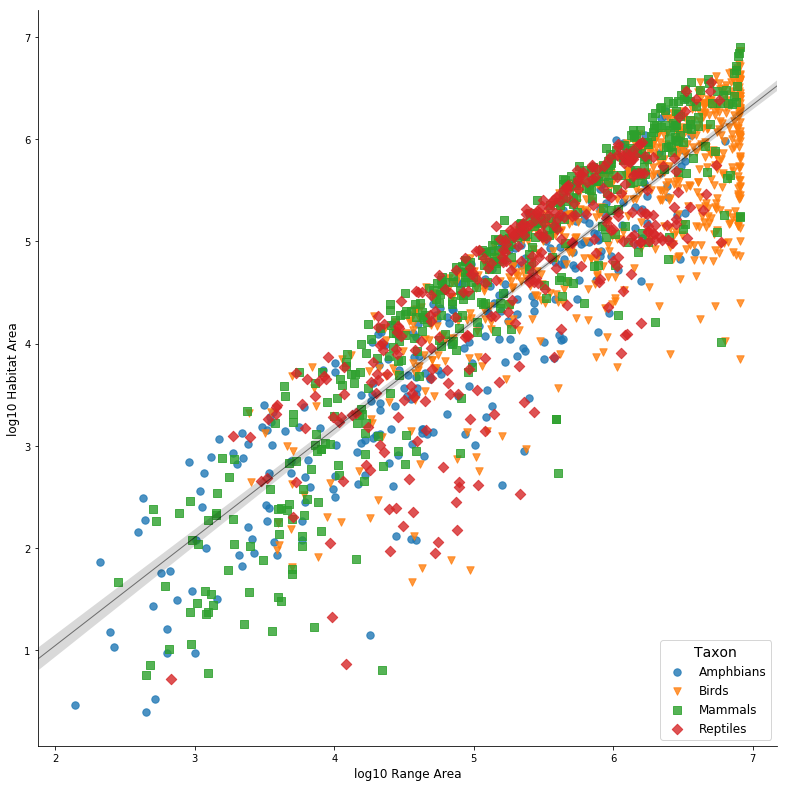

In [21]:
'''
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
Now start manipulating the dataframe to plot log areas for range and habitat

'''

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


## -- Pull out only the species code, log area range, and log area habitat
# reset the index so the species code is no longer the index
dfPlot = dfMaster[['LogAreaRange','LogAreaHabitat']].reset_index()

# create a new Taxon column based on the first letter in the species code
dfPlot['Taxon'] = np.where(dfPlot['SpeciesCode'].str[:1]=='a', 'Amphbians',
		  np.where(dfPlot['SpeciesCode'].str[:1]=='b', 'Birds',
		  np.where(dfPlot['SpeciesCode'].str[:1]=='m', 'Mammals', 'Reptiles')))


a = sns.lmplot(x="LogAreaRange", y="LogAreaHabitat", 
               hue="Taxon", data=dfPlot, fit_reg=False, legend=False,
               markers=['o','v','s','D'], size=11,
               scatter_kws={'s': 55})

pax = sns.regplot(x="LogAreaRange", y="LogAreaHabitat", 
            data=dfPlot, scatter=False, ax=a.axes[0, 0],
            line_kws={"color":"black","alpha":0.5,"lw":1})
pax.set_xlabel('log10 Range Area', fontsize=12)
pax.set_ylabel('log10 Habitat Area', fontsize=12)


# Move the legend to an empty part of the plot
lgd = plt.legend(loc='lower right', title='Taxon', prop={'size':12})
lgd.get_title().set_fontsize(14)

### Run an Ordinary Least Squares regression on range v. habitat area <a name="OLSsummary"></a>

In [22]:
# Run an OLS regression of habitat and range and get an r-squared for the relationship
lm = sm.OLS.from_formula(formula='LogAreaHabitat ~ LogAreaRange', data=dfPlot)
result = lm.fit()
print(result.summary())
r2=result.rsquared
print('\n The r-squared for log habitat area given log range area =', r2)

                            OLS Regression Results                            
Dep. Variable:         LogAreaHabitat   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     6279.
Date:                Tue, 12 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:13:02   Log-Likelihood:                -1488.0
No. Observations:                1715   AIC:                             2980.
Df Residuals:                    1713   BIC:                             2991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0719      0.074    -14.465   

## Citations <a name="citations"></a>

Beresford AE, GM Buchanan, PF Donald, SHM Butchart, LDC Fishpool, et al. (2011) Poor overlap between the distribution of protected areas and globally threatened birds in Africa. Animal Conservation 14: 99–107. http://doi.wiley.com/10.1111/j.1469-1795.2010.00398.x

Freckleton, RP, D Noble, and TJ Webb. (2006) Distributions of habitat suitability and the abundance-occupancy relationship. The American Naturalist 167:260-275. https://doi.org/10.1086/498655

Gaston KJ, and RA Fuller. (2009) The sizes of species' geographic ranges. Journal of Applied Ecology 46:1-9.  https://doi.org/10.1111/j.1365-2664.2008.01596.x

Graham, CH, and RJ Hijmans. (2006) A comparison of methods for mapping species ranges and species richness. Global Ecology and Biogeography 15:578-587.  https://doi.org/10.1111/j.1466-8238.2006.00257.x

Harris, G, and SL Pimm. (2008) Range size and extinction risk in forest birds. Conservation Biology, 22, 163-171. https://doi.org/10.1111/j.1523-1739.2007.00798.x

Jetz, W, CH Sekercioglu, and JEM Watson. (2008) Ecological correlates and conservation implications of overestimating species geographic ranges. Conservation Biology, 22, 110-119. https://doi.org/10.1111/j.1523-1739.2007.00847.x

McKerrow, AJ, NM Tarr, MJ Rubino, and SG Williams. (2018) Patterns of species richness hotspots and estimates of their protection are sensitive to spatial resolution. Diversity and Distributions 24:1461-1477, https://doi.org/10.1111/ddi.12779

Rondinini, C, M Di Marco, F Chiozza, G Santulli, D Baisero, P Visconti, and L Boitani. (2011). Global habitat suitability models of terrestrial mammals. Philosophical Transaction of the Royal Society B: Biological Sciences, 366, 2633-2641. https://doi.org/10.1098/rstb.2011.0113